In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/train.csv


In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

#Setting the Theme of the data visualizer Seaborn
sns.set(style="dark",context="notebook",palette="muted")

print("TensorFlow Version:   "+tf.version.VERSION)
print("Keras Version:   "+tf.keras.__version__)

TensorFlow Version:   2.3.1
Keras Version:   2.4.0


In [3]:
train = pd.read_csv("../input/digit-recognizer/train.csv")
test = pd.read_csv("../input/digit-recognizer/test.csv")

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

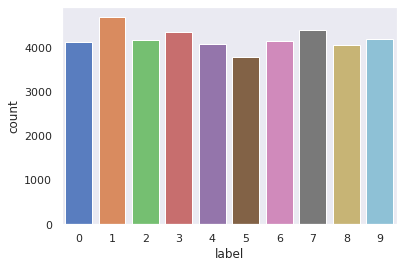

In [4]:
Y_train = train['label']

#Dropping Label Column
X_train = train.drop(labels=['label'],axis=1)

#free up some space
del train

graph = sns.countplot(Y_train)
 
Y_train.value_counts()

In [5]:
X_train.isnull().any().describe()

test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [6]:
print (X_train.shape)
print (Y_train.shape)
print (test.shape)

(42000, 784)
(42000,)
(28000, 784)


In [7]:
Y_train = tf.keras.utils.to_categorical(Y_train, num_classes=10)
print (Y_train.shape)

(42000, 10)


In [8]:
X_train = X_train/255
test = test/255

X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

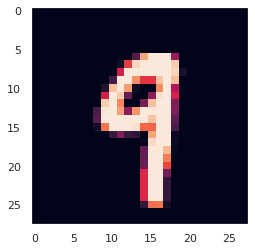

In [9]:
#Spliting Train and test set
random_seed =2

X_train,X_val,Y_train,Y_val = train_test_split(X_train,Y_train,test_size=0.1,
                                               random_state = random_seed)


g = plt.imshow(X_train[2][:,:,0])

In [10]:
print (X_train.shape)
print (Y_train.shape)
print (test.shape)

(37800, 28, 28, 1)
(37800, 10)
(28000, 28, 28, 1)


In [11]:
model = tf.keras.Sequential()

model.add(layers.Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation=tf.nn.relu, input_shape = (28,28,1)))
model.add(layers.Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation=tf.nn.relu))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation=tf.nn.relu, input_shape = (28,28,1)))
model.add(layers.Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation=tf.nn.relu))
model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation=tf.nn.relu))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(10,activation=tf.nn.softmax))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0

In [13]:
optimizer = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics=["accuracy"])

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc',
                                                               patience=3,
                                                               verbose=1,
                                                               factor=0.5,
                                                               min_lr=0.00001)


In [14]:
epochs=1
batch_size = 112

history = model.fit(X_train,Y_train, 
                    batch_size=batch_size,
                    epochs = epochs, 
                    validation_data = (X_val,Y_val),
                    verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size,
                    callbacks=[learning_rate_reduction])

337/337 - 132s - loss: 0.2397 - accuracy: 0.9231 - val_loss: 0.0675 - val_accuracy: 0.9776


In [15]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [16]:
print (results)

0        2
1        0
2        9
3        9
4        3
        ..
27995    9
27996    7
27997    3
27998    9
27999    2
Name: Label, Length: 28000, dtype: int64


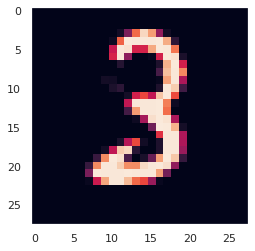

In [17]:
plt.imshow(test[4][:,:,0])

In [18]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_datagen.csv",index=False)